In [46]:
import pulse2percept as p2p
import numpy as np
import matplotlib.pyplot as plt
import torch
import math
import cv2

import sys
sys.path.append('../ZoeDepth')
from zoedepth.utils.misc import get_image_from_url, colorize
from PIL import Image

%matplotlib inline

In [47]:
zoe = torch.hub.load("../ZoeDepth", "ZoeD_N", source="local", pretrained=True)

img_size [384, 512]


Using cache found in C:\Users\csirlin/.cache\torch\hub\intel-isl_MiDaS_master


Params passed to Resize transform:
	width:  512
	height:  384
	resize_target:  True
	keep_aspect_ratio:  True
	ensure_multiple_of:  32
	resize_method:  minimal
Using pretrained resource url::https://github.com/isl-org/ZoeDepth/releases/download/v1.0/ZoeD_M12_N.pt
Loaded successfully


In [48]:
# img_url = "http://static1.squarespace.com/static/6213c340453c3f502425776e/62f2452bc121595f4d87c713/62f3c63c5eec2b12a333f851/1661442296756/Screenshot+2022-08-10+at+15.55.27.png?format=1500w" #@param {type:"string"}
# img = get_image_from_url(img_url)
img = Image.open('depth.jpg')
depth = zoe.infer_pil(img)
img = np.array(img)

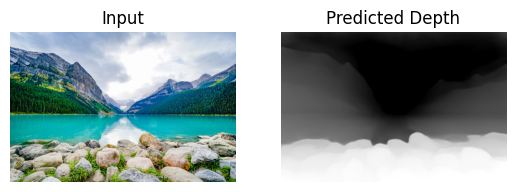

In [49]:
colored_depth = colorize(depth)
fig, axs = plt.subplots(1,2)
for ax, im, title in zip(axs, [img, colored_depth], ['Input', 'Predicted Depth']):
  ax.imshow(im)
  ax.axis('off')
  ax.set_title(title)

In [50]:
# print info about the depth image. depth is in meters
print(depth.shape, depth.max(), depth.min(), depth.mean())

(720, 1080) 5.4121437 1.1850127 3.3651345


In [51]:
x_map, y_map = np.meshgrid(np.arange(depth.shape[1]), np.arange(depth.shape[0]))
print(x_map)

[[   0    1 ... 1078 1079]
 [   0    1 ... 1078 1079]
 ...
 [   0    1 ... 1078 1079]
 [   0    1 ... 1078 1079]]


In [52]:
# compute shifted image
fov = 60
fov_rad = fov * math.pi / 180
x = depth.shape[1] # width in pixels
eye_dist = 0.063 # on average, eyes are 63mm apart
x_displaced = x_map + x*eye_dist/(2*depth*np.tan(fov_rad/2))
x_displaced = np.clip(x_displaced, 0, x-1)
warped_image = cv2.remap(img, x_displaced.astype(np.float32), y_map.astype(np.float32), cv2.INTER_LINEAR)

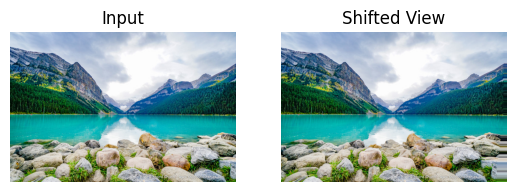

In [53]:
fig, axs = plt.subplots(1,2)
for ax, im, title in zip(axs, [img, warped_image], ['Input', 'Shifted View']):
  ax.imshow(im)
  ax.axis('off')
  ax.set_title(title)

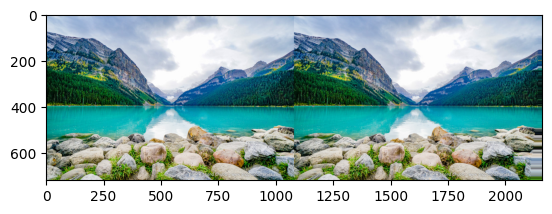

In [63]:
# look closely to get the magic eye/3D effect
img_and_warped = np.hstack((img, warped_image))
plt.imshow(img_and_warped)

<AxesSubplot: xlabel='x (microns)', ylabel='y (microns)'>

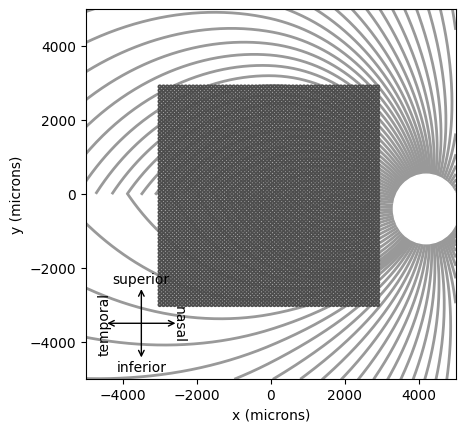

In [ ]:
### pulse2percept time ###

# start with a really idealistic model with tons of electrodes
full_array = p2p.implants.ElectrodeArray([])
e_count = 0
for i in range(-3000, 3000, 100):
    for j in range(-3000, 3000, 100):
        full_array.add_electrode(e_count, p2p.implants.DiskElectrode(i, j, z=0, r=25))
        e_count += 1
full_array.plot()
p2p.models.AxonMapModel().plot()

<AxesSubplot: xlabel='x (microns)', ylabel='y (microns)'>

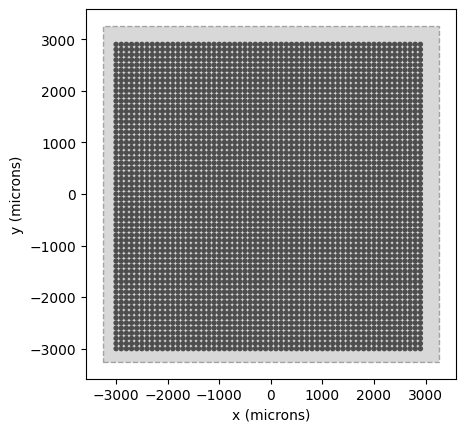

In [65]:
model = p2p.models.ScoreboardModel(xrange=(-12, 12), yrange=(-12, 12), xystep=0.1, rho=100)
model.build()
model.plot()
full_array.plot()

In [66]:
def get_percept_data_from_image(image):
    full_prosthesis = p2p.implants.ProsthesisSystem(full_array, p2p.stimuli.ImageStimulus(image))
    percept = model.predict_percept(full_prosthesis)
    return percept.data

percept_left = get_percept_data_from_image(img)
percept_right = get_percept_data_from_image(warped_image)

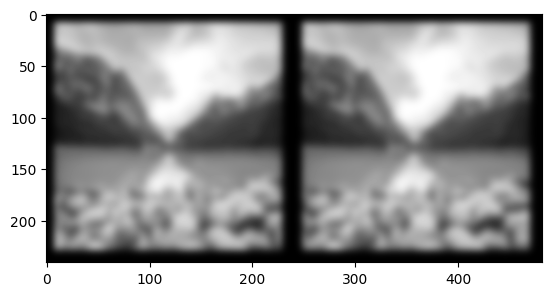

In [67]:
# percepts still have the effect!
percept_side_by_side = np.hstack((percept_left, percept_right))
plt.imshow(percept_side_by_side, cmap='gray')

In [68]:
# now try argus II
implant = p2p.implants.ArgusII()
model = p2p.models.ScoreboardModel(xrange=(-12, 12), yrange=(-12, 12), xystep=0.1, rho=100)
model.build()

implant.stim = p2p.stimuli.ImageStimulus(img)
percept_left = model.predict_percept(implant)
implant.stim = p2p.stimuli.ImageStimulus(warped_image)
percept_right = model.predict_percept(implant)

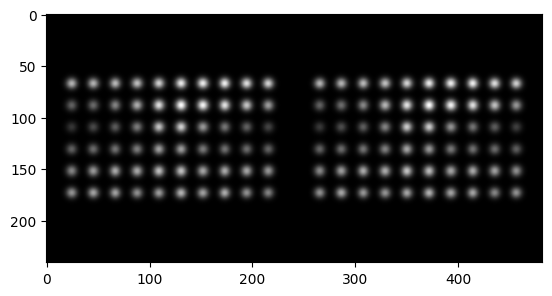

In [69]:
# resulting view is basically useless
percept_side_by_side = np.hstack((percept_left.data, percept_right.data))
plt.imshow(percept_side_by_side, cmap='gray')

In [61]:
# full_array = p2p.implants.ElectrodeArray([])
# e_count = 0
# for i in range(-3000, 3000, 100):
#     for j in range(-3000, 3000, 100):
#         full_array.add_electrode(e_count, p2p.implants.DiskElectrode(i, j, z=0, r=25))
#         e_count += 1
# full_array.plot()
# p2p.models.AxonMapModel().plot()

# model = p2p.models.ScoreboardModel(xrange=(-12, 12), yrange=(-12, 12), xystep=0.1, rho=100)
# model.build()
# model.plot()
# full_array.plot()

# def get_percept_data_from_image(image):
#     full_prosthesis = p2p.implants.ProsthesisSystem(full_array, p2p.stimuli.ImageStimulus(image))
#     percept = model.predict_percept(full_prosthesis)
#     return percept.data

# percept_left = get_percept_data_from_image(img)
# percept_right = get_percept_data_from_image(warped_image)

# percept_side_by_side = np.hstack((percept_left, percept_right))
# plt.imshow(percept_side_by_side, cmap='gray')